In [1]:
#
# global memory mode - cortical associative memory
# 
import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

In [10]:
class HTMEncoder(nn.Module):
    def __init__(self, vocab, cells_per_column=16):
        super().__init__()
        self.vocab = vocab
        self.columns = len(vocab)
        self.cells_per_column = cells_per_column
        self.total_cells = self.columns * self.cells_per_column
        self.col_to_word = {col_idx: word for word, col_idx in vocab.items()}
        self.word_to_cells = {
            word: self._allocate_cells(idx) for word, idx in vocab.items()
        }

    def _allocate_cells(self, column_idx):
        start = column_idx * self.cells_per_column
        return [start]

    def encode(self, word):
        vec = torch.zeros(self.total_cells)
        for i in self.word_to_cells.get(word, []):
            vec[i] = 1.0
        return vec

    def decode(self, vec):
        active_cells = torch.nonzero(vec).flatten().tolist()
        col_indices = {i // self.cells_per_column for i in active_cells}
        return [self.col_to_word.get(col, "<unknown>") for col in col_indices]


class DeterministicHTPC:
    def __init__(self, word_list, cells_per_column=16, blacklist=None):
        self.vocab = {word: i for i, word in enumerate(sorted(set(word_list)))}
        self.encoder = HTMEncoder(self.vocab, cells_per_column=cells_per_column)
        self.transition_counts = defaultdict(int)
        self.last_encoded = None
        self.blacklist = set((w1.lower(), w2.lower()) for w1, w2 in (blacklist or []))
        self.l2_index = {}  # (word1, word2) → index
        self.l2_size = 0
        self.L2_state = None


    def train_pair(self, word1, word2):
        if (word1.lower(), word2.lower()) in self.blacklist:
            return  # Skip blacklisted pair

        pre = self.encoder.encode(word1)
        post = self.encoder.encode(word2)
        for i in torch.nonzero(pre).flatten():
            for j in torch.nonzero(post).flatten():
                self.transition_counts[(i.item(), j.item())] += 1
        key = (word1.lower(), word2.lower())
        if key not in self.l2_index:
            self.l2_index[key] = self.l2_size
            self.l2_size += 1
        self.update_L2_state(word1, word2)


    def input_word(self, word):
        self.last_encoded = self.encoder.encode(word)

    def predict_next(self, top_k=3, return_probs=False):
        if self.last_encoded is None:
            return ["<no_input>"]
        pre_indices = torch.nonzero(self.last_encoded).flatten().tolist()
        post_counts = defaultdict(float)
        for pre in pre_indices:
            for (p, q), count in self.transition_counts.items():
                if p == pre:
                    post_counts[q] += count
        if not post_counts:
            return ["<unknown>"]
        total = sum(post_counts.values())
        sorted_posts = sorted(post_counts.items(), key=lambda x: -x[1])
        top_post_indices = sorted_posts[:top_k]
        result = []
        for post_idx, count in top_post_indices:
            word = self.encoder.decode(torch.eye(self.encoder.total_cells)[post_idx])[0]
            prob = count / total
            result.append((word, round(prob, 3)) if return_probs else word)
        return result

    def simulate_forward(self, start_word="<BOS>", steps=5):
        self.input_word(start_word)
        sequence = [start_word]
        for _ in range(steps):
            preds = self.predict_next(top_k=1)
            next_word = preds[0] if isinstance(preds[0], str) else preds[0][0]
            if next_word in ("<unknown>", "<EOS>"):
                break
            sequence.append(next_word)
            self.input_word(next_word)
        return sequence

    def update_L2_state(self, word1, word2):
        self.L2_state = torch.zeros(self.l2_size)
        key = (word1.lower(), word2.lower())
        if key in self.l2_index:
            self.L2_state[self.l2_index[key]] = 1.0
    
    def export_transition_graph(self):
        G = nx.DiGraph()

        # Step 1: Group all outgoing transitions by source (pre)
        outgoing_totals = defaultdict(float)
        for (pre, post), count in self.transition_counts.items():
            outgoing_totals[pre] += count

        # Step 2: Build graph with normalized edge weights
        for (pre, post), count in self.transition_counts.items():
            w1 = self.encoder.decode(torch.eye(self.encoder.total_cells)[pre])[0]
            w2 = self.encoder.decode(torch.eye(self.encoder.total_cells)[post])[0]
            prob = count / outgoing_totals[pre]
            G.add_edge(w1, w2, weight=prob)

        # Step 3: Draw graph with probabilities as edge labels
        pos = nx.spring_layout(G, seed=42)
        edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # Scale for line thickness
        edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, node_color='lightblue',
                edge_color='gray', width=edge_weights, font_size=10)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    
        plt.title("HTPC Transition Graph (Edge Labels = Probabilities)")
        plt.show()

    def export_graph_with_L2_nodes(self):
        G = nx.DiGraph()

        # Track total outgoing transitions for normalization
        outgoing_totals = defaultdict(float)
        for (pre, post), count in self.transition_counts.items():
            outgoing_totals[pre] += count

        # Build graph with L2 transitions as intermediate nodes
        for (pre, post), count in self.transition_counts.items():
            prob = count / outgoing_totals[pre]

            # Decode actual words
            w1 = self.encoder.decode(torch.eye(self.encoder.total_cells)[pre])[0]
            w2 = self.encoder.decode(torch.eye(self.encoder.total_cells)[post])[0]

            # Create unique L2 node
            l2_node = f"L2_{w1}→{w2}"

            # Add nodes and edges
            G.add_node(w1, layer='L1', color='skyblue')
            G.add_node(w2, layer='L1', color='skyblue')
            G.add_node(l2_node, layer='L2', color='orange')

            G.add_edge(w1, l2_node, type="encode", weight=1.0)
            G.add_edge(l2_node, w2, type="decode", weight=prob)

        # Visualize
        pos = nx.spring_layout(G, seed=42)

        node_colors = [G.nodes[n]['color'] for n in G.nodes()]
        edge_weights = [G[u][v]['weight'] * 4 for u, v in G.edges()]
        edge_labels = {
            (u, v): f"{G[u][v]['weight']:.2f}" if 'weight' in G[u][v] else ""
            for u, v in G.edges()
        }

        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                edge_color='gray', width=edge_weights, font_size=9)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    
        plt.title("HTPC Graph with L2 Transition Nodes")
        plt.show()

    def export_graphml_with_L2_nodes_graphml(self, filename="htpc_l1_l2.graphml"):
        import networkx as nx

        G = nx.DiGraph()

        # Track outgoing counts for normalization
        outgoing_totals = defaultdict(float)
        for (pre, post), count in self.transition_counts.items():
            outgoing_totals[pre] += count

        # Build graph with L2 transition nodes
        for (pre, post), count in self.transition_counts.items():
            prob = count / outgoing_totals[pre]
            w1 = self.encoder.decode(torch.eye(self.encoder.total_cells)[pre])[0]
            w2 = self.encoder.decode(torch.eye(self.encoder.total_cells)[post])[0]
            l2_node = f"L2_{w1}→{w2}"

            # Add nodes
            G.add_node(w1, layer="L1")
            G.add_node(w2, layer="L1")
            G.add_node(l2_node, layer="L2")

            # Add edges
            G.add_edge(w1, l2_node, type="encode", weight=1.0)
            G.add_edge(l2_node, w2, type="decode", weight=prob)

        # Export to GraphML
        nx.write_graphml(G, filename)
        print(f"Graph exported to {filename}")



In [11]:
#with open("corpus.txt", "r") as f:
#    corpus = [line.strip() for line in f if line.strip()]

#corpus = [
#    "the cat sat on the mat",
#    "the dog ran across the yard",
#    "a cat jumped on the table"
#    "a cat hide below the table",
#    "the dog barks loud"
#]

corpus = [
    "spec noun fin adp spec noun",
    "spec noun fin adp spec noun",
    "spec noun fin"
    "pron inf pron adp noun",
    "pron inf state adp inf",
    "spec noun mod fin spec noun adp spec noun",
    "pron fin mod"
]


def extract_sequences_with_bos_eos(lines):
    all_words = set()
    global_pairs = []

    for line in lines:
        tokens = re.findall(r'\b\w+\b', line.lower())
        if not tokens:
            continue

        # Add BOS and EOS
        tokens = ["<BOS>"] + tokens + ["<EOS>"]
        all_words.update(tokens)

        pairs = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
        global_pairs.extend(pairs)

    return sorted(all_words), global_pairs



# Build vocab and 2-gram pairs
vocab, all_pairs = extract_sequences_with_bos_eos(corpus)

blacklisted_pairs = [("fin", "spec"), ("adp", "spec"), ("fin", "adp")]

# Init and train
model = DeterministicHTPC(word_list=vocab, cells_per_column=16, blacklist=blacklisted_pairs)
for w1, w2 in all_pairs:
    model.train_pair(w1, w2)


In [4]:
# Start from <BOS> to simulate full sentence
simulated = model.simulate_forward("<BOS>", steps=10)
print("Simulated from <BOS>:", simulated)

model.input_word("spec")
print("Predictions after 'spec':", model.predict_next(return_probs=True))
pred = model.predict_next()
model.update_L2_state("spec", pred[0])

print("L1 state (spec):", model.last_encoded.nonzero().flatten().tolist())
print("L2 state (spec → ?):", model.L2_state.nonzero().flatten().tolist())

model.input_word("fin")
print("Predictions after 'fin':", model.predict_next(return_probs=True))

model.input_word("adp")
print("Predictions after 'adp':", model.predict_next(return_probs=True))

model.input_word("@spec")
print("Forward simulation:", model.simulate_forward("noun", steps=5))


Simulated from <BOS>: ['<BOS>', 'spec', 'noun']
Predictions after 'spec': [('noun', 1.0)]
L1 state (spec): [144]
L2 state (spec → ?): [1]
Predictions after 'fin': [('mod', 1.0)]
Predictions after 'adp': [('noun', 0.5), ('inf', 0.5)]
Forward simulation: ['noun']


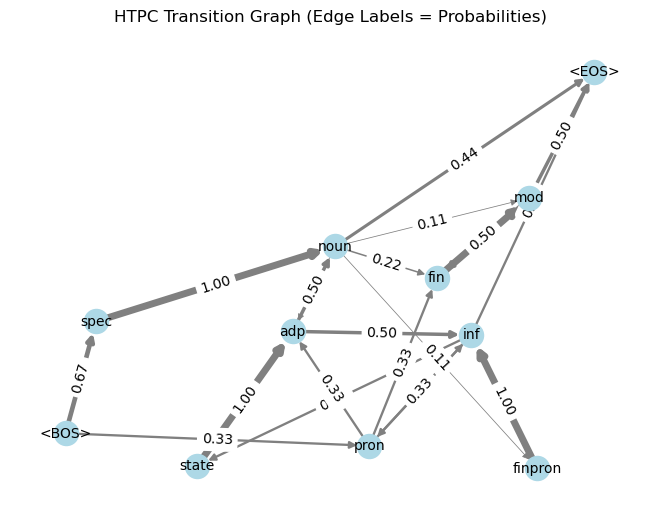

In [8]:
model.export_transition_graph()


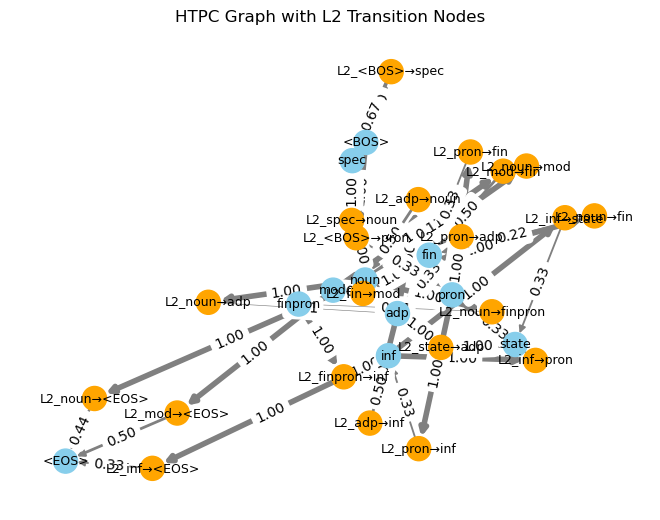

In [9]:
model.export_graph_with_L2_nodes()


In [13]:
model.export_graphml_with_L2_nodes_graphml("htpc_l1_l2.graphml")


Graph exported to htpc_l1_l2.graphml
